In [27]:
%matplotlib inline
import sympy as sp
from sympy import cos, sin, pi, sqrt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.style.use('pub_fast')
sp.init_printing()
sp.var('θ, M0, Mπ, A, B, C')

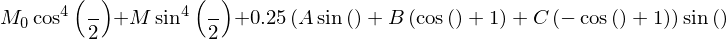

In [12]:
def M(θ):
    return sp.cos(θ/2)**4*M0+sp.sin(θ/2)**4*Mπ+(1/4)*sp.sin(θ)*(sp.sin(θ)*A+(1+sp.cos(θ))*B+(1-sp.cos(θ))*C)
M(θ)

In [13]:
4*(M(sp.pi/4)-M(-sp.pi/4)-1/sp.sqrt(2)*(M(sp.pi/2)-M(-sp.pi/2))).simplify()

In [14]:
2*(M(sp.pi/2)-M(-sp.pi/2)).simplify()

In [15]:
(2*(M(sp.pi/2)+M(-sp.pi/2))-(M0+Mπ)).simplify()

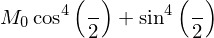

In [16]:
sp.expand_trig(sp.cos(θ/2)**4*M0+sp.sin(θ/2)**4)

0
-4.61677387493098 -4.61677387493098 -4.616773874930985


/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


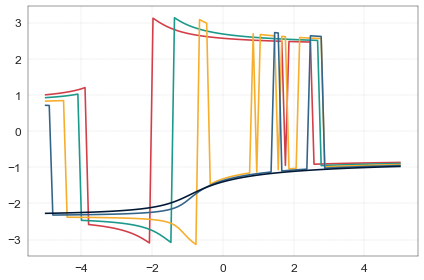

In [33]:
import scipy.optimize as opt
a, b, c, d = 1, 2, 3, 4
def M(x): return a*sp.sin(2*x)+b*sp.sin(2*x)+c*sp.cos(x)+d*sp.sin(x)

def M_(θ):
    return (cos(θ/2)**4)*M(0)+sin(θ/2)**4*M(pi)+(1/4)*sin(θ)**2*(2*(M(pi/2)+M(-pi/2))-(M(0)+M(pi)))+\
        (1/2)*sin(θ)*(M(pi/2)-M(-pi/2))+\
        (1/4)*sin(θ)*cos(θ)*(4*((M(pi/4)-M(-pi/4))-(1/sqrt(2))*(M(pi/2)-M(-pi/2))))

def MM(x):
    A = (M(0)+M(np.pi)).evalf()
    B = (M(0)-M(np.pi)).evalf()
    C = (M(np.pi/2)+M(-np.pi/2)).evalf()
    D = (M(np.pi/2)-M(-np.pi/2)).evalf()
    E = (M(np.pi/4)-M(-np.pi/4)).evalf()
    a, b, c, d = 1/4*(2*E-np.sqrt(2)*D), 1/4*(A-C), 1/2*D, 1/2*B
    return a*np.sin(2*x)+b*np.cos(2*x)+c*np.sin(x)+d*np.cos(x)
    #return (1/4)*((A-C)*np.cos(2*x)+(2*E-np.sqrt(2)*D)*np.sin(2*x))+(1/2)*(B*np.cos(x)+D*np.sin(x))

def MM2(x):
    A = float((M(0)+M(np.pi)).evalf())
    B = float((M(0)-M(np.pi)).evalf())
    C = float((M(np.pi/2)+M(-np.pi/2)).evalf())
    D = float((M(np.pi/2)-M(-np.pi/2)).evalf())
    E = float((M(np.pi/4)-M(-np.pi/4)).evalf())
    a, b, c, d = 1/4*(2*E-np.sqrt(2)*D), 1/4*(A-C), 1/2*D, 1/2*B

    P = np.sqrt(a**2+b**2)
    u = np.arctan2(b, a)
    
    Q = np.sqrt(c**2+d**2)
    v = np.arctan2(d, c)
    
    return P*np.sin(2*x+u)+Q*np.sin(x+v)

    
print((M_(θ)-M(θ)).simplify())

print(MM(5), M(5).evalf(), MM2(5))

#x = np.linspace(-np.pi, np.pi)
#plt.plot(x, [M_(X).evalf() for X in x])
#plt.plot(x, MM(x))
#plt.plot(x, MM2(x))
#x_= opt.minimize_scalar(MM2).x
#plt.scatter(x_, MM2(x_))

def mini(a, b, c, d):
    def M(x): return a*sp.sin(2*x)+b*sp.sin(2*x)+c*sp.cos(x)+d*sp.sin(x)
    def MM2(x):
        A = float((M(0)+M(np.pi)).evalf())
        B = float((M(0)-M(np.pi)).evalf())
        C = float((M(np.pi/2)+M(-np.pi/2)).evalf())
        D = float((M(np.pi/2)-M(-np.pi/2)).evalf())
        E = float((M(np.pi/4)-M(-np.pi/4)).evalf())
        a, b, c, d = 1/4*(2*E-np.sqrt(2)*D), 1/4*(A-C), 1/2*D, 1/2*B

        P = np.sqrt(a**2+b**2)
        u = np.arctan2(b, a)

        Q = np.sqrt(c**2+d**2)
        v = np.arctan2(d, c)

        return P*np.sin(2*x+u)+Q*np.sin(x+v)
    return opt.minimize_scalar(MM2, method='brent').x
X = np.linspace(-5, 5, 100)
def wrap(x): return np.arctan2(np.sin(x), np.cos(x))
Y = np.linspace(0, 5, 5)
for y in Y:
    plt.plot(X, [wrap(mini(x, b, c, y)) for x in X]);

In [1]:
from xmps.iMPS import iMPS, Map
from rotosolve import double_rotosolve, gate
from qmps.represent import FullStateTensor
from qmps.tools import environment_from_unitary, unitary_to_tensor
import cirq 
import numpy as np
from scipy.linalg import expm
from qmps.ground_state import Hamiltonian

/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def evo_state(params, which, old_params, H, dt):
    assert len(params)==30
    p2, p1 = np.split(params, 2)
    p2_, p1_ = np.split(old_params, 2)
    if which=='energy':
        qbs = cirq.LineQubit.range(4)
        C = cirq.Circuit.from_ops([gate(p1_)(*qbs[2:]),
                                   gate(p2_)(*qbs[1:3]),
                                   gate(p2_)(*qbs[:2]), 
                                   FullStateTensor(expm(-1j*H*dt/2))(*qbs[1:3]),
                                   cirq.inverse(gate(p2))(*qbs[:2]),
                                   cirq.inverse(gate(p2))(*qbs[1:3]),
                                   cirq.inverse(gate(p1))(*qbs[2:])])
        s = cirq.Simulator()
        return s.simulate(C).final_state
    elif which=='v_purity':
        qbs = [[cirq.GridQubit(y, x) for x in range(2)] 
                for y in range(2)]
        C = cirq.Circuit.from_ops([gate(p1)(*qbs[0][:2]),
                                   gate(p1)(*qbs[1][:2]), 
                                   cirq.SWAP(*qbs[0][:2])])
        s = cirq.Simulator()
        return s.simulate(C).final_state
    elif which=='u_purity':
        qbs = [[cirq.GridQubit(y, x) for x in range(3)]
                for y in range(2)]
        C = cirq.Circuit.from_ops([gate(p1)(*qbs[0][1:]), 
                                   gate(p2)(*qbs[0][:2]),
                                   gate(p1)(*qbs[1][1:]), 
                                   gate(p2)(*qbs[1][:2]), 
                                   cirq.SWAP(*qbs[0][:2]), 
                                   cirq.SWAP(*qbs[0][1:])])
        s = cirq.Simulator()
        return s.simulate(C).final_state
    elif which=='uv_purity':
        qbs = cirq.LineQubit.range(5)
        C = cirq.Circuit.from_ops([gate(p1)(*qbs[3:]), 
                                   gate(p2)(*qbs[2:4]), 
                                   gate(p1)(*qbs[:2]), 
                                   cirq.SWAP(*qbs[:2])])
        s = cirq.Simulator()
        return s.simulate(C).final_state

    

In [20]:
N=10
Ps = []
for i in range(N):
    dt = 0.2# if i==0 else 0.01
    p_initial = np.random.randn(30)
    p_old = p_initial
    #evo_state(p, p_old, Hamiltonian({'ZZ':-1, 'X':2}).to_matrix(), dt=0.01, which='energy')
    H = -np.diag(np.eye(16)[0])
    p_ , es= double_rotosolve(H, 
                              evo_state, 
                              p_initial, 
                              args=(p_old, Hamiltonian({'X':1}).to_matrix(), dt), 
                              N_iters=50);

    Ps.append([p_, es])
    p_initial = p_old = p_
    print(es)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.9948473131725217, 0.8478212356226975, 0.8647100660965328, -1.7112463802091142)0.001284921510116055
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.9951592550875787, 0.8181460792975894, 0.8479901911149186, -1.665292901609273)0.0008433688032349895
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.9953978365117848, 0.7939229136489603, 0.8255155916801923, -1.6184948386162339)0.0009436667129185672
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.9954873495953409, 0.7737423010155331, 0.8021875087503259, -1.5751512661794045)0.000778543586454461
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.9954625111558483, 0.757

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.994872339331041, 0.6003706976476039, 0.5991850299556445, -1.1995101402443678)4.558735888071652e-05
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.9947929114204043, 0.5993235894649884, 0.5982605993972318, -1.197538333143383)4.585571883697348e-05
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.9947155530974667, 0.5985478738174774, 0.5978885571687944, -1.1963887813525949)4.764963367698272e-05
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.9946413220908114, 0.5978525942591788, 0.5979234648645606, -1.1957240467042558)5.201241948360469e-05
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.9945682852922803, 0.59

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.9948624633556611, 0.7082158693782118, 0.7065914389415515, -1.4140346622176685)0.0007726461020947095
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.9949308362092759, 0.7094373616262548, 0.7079483451854054, -1.4166967810144264)0.0006889257972337859
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.9949329645817604, 0.7122246877694166, 0.7110057060416051, -1.4226117912492746)0.0006186025617471724
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.9948955191166933, 0.7163087154681236, 0.7154571267947893, -1.431193055307712)0.0005727869552010212
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

(-0.9948517003028323, 0.7

KeyboardInterrupt: 

In [ ]:
p1, p2 = np.split(p, 2)
p1_, p2_ = np.split(p_old, 2)

V, U = cirq.unitary(gate(p1)), cirq.unitary(gate(p2))
V_, U_ = cirq.unitary(gate(p1_)), cirq.unitary(gate(p2_))


A, c = unitary_to_tensor(U), environment_from_unitary(V)
A_, c_ = unitary_to_tensor(U_), environment_from_unitary(V_)

In [7]:
Map(A, A_).left_fixed_point()

(array([0.64844639-0.49438946j]),
 array([[ 0.10186952-0.96072824j,  0.10353037+0.08694944j],
        [-0.39257035+0.37910003j, -0.1668741 -0.41254753j]]))

In [ ]:
for 